In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
from plotnine import *

In [2]:
# Import for comparison
project_dir = str(Path(os.getcwd()).parent)
datasets_path = str(Path(os.getcwd()).parent) + "/datasets/"
df = pd.read_csv(datasets_path + "down_detector_outage_count.csv")

# df_2018 = pd.read_parquet(datasets_path + "2018_fixed_sesaeet.parquet")
# df_2019 = pd.read_parquet(datasets_path + "2019_fixed_sesaeet.parquet")
# df_2020 = pd.read_parquet(datasets_path + "2020_fixed_sesaeet.parquet") # When 2020 is cleaned and ready
# df_vendor = df_2019.append(df_2018).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)
# df_vendor = df_2020.append(df_vendor).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)

In [3]:

def extract_failure_event_times(partial_df):
    start_time = None
    end_time = None
    num_reports_list = []
    failure_events = []
    page_ids = partial_df.sort_values("timestamp")['event_id'].unique()

    q_val = 0.75
    # Extract event_start and event_end from each event
    event_id = 0
    for page_id in page_ids:
        df_page = partial_df[partial_df["event_id"] == page_id].sort_values("timestamp")
        threshold = df_page["count"].quantile(q_val) 
        while threshold == 0:
            q_val += 0.05
            threshold = df_page["count"].quantile(q_val)
        
        for i, page in df_page.sort_values("timestamp").iterrows():
            nr_reports = page['count']
            event_time = page['timestamp']
            vendor = page['provider']

            if nr_reports > threshold:
                if start_time == None:
                    start_time = event_time

                num_reports_list.append(nr_reports)

            else:
                if start_time != None:
                    end_time = event_time
                    if 900 * 95 > end_time - start_time > 0: # If duration is longer than 23:45, don't add it.
                        failure_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'duration': end_time-start_time,
                            'peak': np.max(num_reports_list),
                            'threshold': threshold,
                            'median': np.median(num_reports_list),
                            'mean': np.mean(num_reports_list),
                            'page_id': page_id,
                            'event_id': event_id,
                            'vendor': vendor
                        })
                        event_id += 1
                        
                    start_time = None
                    end_time = None
                    num_reports_list = []
                    
    return pd.DataFrame(failure_events)



In [4]:
df["date"] = pd.to_datetime(df["timestamp"], unit='s')
print(df[df["provider"] == "aws"].sort_values("date").max())
print(df[df["provider"] == "azure"].sort_values("date").max())
print(df[df["provider"] == "gcp"].sort_values("date").max())

# WORKING ONE

event_id                      69
timestamp           1608363912.0
count                       1884
provider                     aws
date         2020-12-19 07:45:12
dtype: object
event_id                      50
timestamp           1608182770.0
count                       2662
provider                   azure
date         2020-12-17 05:26:10
dtype: object
event_id                      13
timestamp           1607990059.0
count                        225
provider                     gcp
date         2020-12-14 23:54:19
dtype: object


In [5]:
all_how_dfs = []
for vendor in ['aws', 'gcp', 'azure']:
    partial_df = extract_failure_event_times(df[df["provider"] == vendor])
    partial_df["event_start_time"] = pd.to_datetime((partial_df["start_time"]), unit="s")
    partial_df["hourofweek"] = partial_df["event_start_time"].dt.dayofweek*24 + partial_df["event_start_time"].dt.hour
    all_how_dfs.append(partial_df)
how_df = pd.concat(all_how_dfs).reset_index(drop=True)
weekly_failures = (how_df.groupby(["vendor", "hourofweek"]).count().reset_index()
                   .rename(columns={"event_id": "num_failures"})
                   [["vendor", "hourofweek", "num_failures"]])
weekly_failures.to_parquet("../../../weekly_failures/cloud_user_reports.parquet")
weekly_failures

,vendor,hourofweek,num_failures
0,aws,0,1
1,aws,2,2
2,aws,11,1
3,aws,12,2
4,aws,13,2
...,...,...,...
232,gcp,140,1
233,gcp,163,1
234,gcp,164,2
235,gcp,165,1


In [8]:
all_doy_dfs = []
for vendor in ['aws', 'gcp', 'azure']:
    partial_df = extract_failure_event_times(df[df["provider"] == vendor])
    partial_df["event_start_time"] = pd.to_datetime((partial_df["start_time"]), unit="s")
    partial_df["dayofyear"] = partial_df["event_start_time"].dt.dayofyear
    all_doy_dfs.append(partial_df)
doy_df = pd.concat(all_doy_dfs).reset_index(drop=True)
doy_failures = (doy_df.groupby(["vendor", "dayofyear"]).count().reset_index()
                   .rename(columns={"event_id": "num_failures"})
                   [["vendor", "dayofyear", "num_failures"]])
doy_failures.to_parquet("../../../doy_availability/cloud_user_reports.parquet")
doy_failures

,vendor,dayofyear,num_failures
0,aws,4,9
1,aws,5,1
2,aws,9,6
3,aws,10,4
4,aws,61,2
...,...,...,...
172,gcp,268,1
173,gcp,269,1
174,gcp,316,3
175,gcp,341,1


In [9]:
def get_iat_and_dur_med(df, start, end):
    t1 = df[start].sort_values().reset_index(drop=True)
    t2 = np.roll(t1, -1)
    t2[-1] = 0
    iat = t2 - t1
    iat = iat[iat > 0]
    iat_stats = iat.quantile([0.5, 0.95]).to_list()
    dur = df[end] - df[start]
    dur_stats = dur.quantile([0.5, 0.95]).to_list()
    return pd.DataFrame({
        "metric": ["iat", "iat", "dur", "dur"],
        "quantile": ["median", "tail", "median", "tail"],
        "quantity": iat_stats + dur_stats
    })

In [13]:
# Author: Sacheendra Talluri, Link: <url>
def compute_cdf(partial_df, variate):
    count_df = partial_df.groupby(variate)['start_time'].count().reset_index().rename(columns={'start_time':'start_count'}).sort_values(variate).reset_index(drop=True)
    count_df['prop'] = count_df['start_count'].values / count_df['start_count'].sum()
    count_df['cdf'] = count_df['prop'].cumsum()
    return count_df

partial_df_list = []
duration_cdf_df_list = []
peak_cdf_df_list = []
median_cdf_df_list = []
mean_cdf_df_list = []
ia_cdf_df_list = []
ia_count_df_list = []

iat_dur_med_list = []

for vendor in ['aws', 'gcp', 'azure']:
    partial_df = extract_failure_event_times(df[df["provider"] == vendor])
    partial_df['vendor_cat'] = vendor
    partial_df_list.append(partial_df)
    
    partial_duration_cdf_df = compute_cdf(partial_df.copy(), 'duration')
    partial_duration_cdf_df['vendor_cat'] = vendor
    duration_cdf_df_list.append(partial_duration_cdf_df)
    
    partial_peak_cdf_df = compute_cdf(partial_df.copy(), 'peak')
    partial_peak_cdf_df['vendor_cat'] = vendor
    peak_cdf_df_list.append(partial_peak_cdf_df)
    
    partial_median_cdf_df = compute_cdf(partial_df.copy(), 'median')
    partial_median_cdf_df['vendor_cat'] = vendor
    median_cdf_df_list.append(partial_median_cdf_df)
    
    partial_mean_cdf_df = compute_cdf(partial_df.copy(), 'mean')
    partial_mean_cdf_df['vendor_cat'] = vendor
    mean_cdf_df_list.append(partial_mean_cdf_df)
    
    iat_dur_med_df = get_iat_and_dur_med(partial_df, "start_time", "end_time")
    iat_dur_med_df["vendor_cat"] = vendor
    iat_dur_med_list.append(iat_dur_med_df)
    
    # Compute interarrival time
    sorted_partial_df = partial_df.sort_values('start_time').reset_index(drop=True)
    ia_arr = sorted_partial_df['start_time'].diff()
    partial_ia_df = pd.DataFrame({'ia': ia_arr[1:], 'count':1})
    partial_ia_df['vendor_cat'] = vendor
    ia_count_df = partial_ia_df.groupby('ia')['count'].count().reset_index()
    ia_count_df['prop'] = ia_count_df['count'].values / ia_count_df['count'].sum()
    ia_count_df['cdf'] = ia_count_df['prop'].cumsum()
    ia_count_df['vendor_cat'] = vendor
    ia_count_df_list.append(partial_ia_df)
    ia_cdf_df_list.append(ia_count_df)
    
    
vendor_list = ['aws', 'gcp', 'azure']

all_partial_df = pd.concat(partial_df_list).reset_index(drop=True)
all_partial_df['vendor_cat'] = pd.Categorical(all_partial_df['vendor_cat'], ordered=True, categories=vendor_list)
    
duration_cdf_df = pd.concat(duration_cdf_df_list).reset_index(drop=True)
duration_cdf_df['vendor_cat'] = pd.Categorical(duration_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

peak_cdf_df = pd.concat(peak_cdf_df_list).reset_index(drop=True)
peak_cdf_df['vendor_cat'] = pd.Categorical(peak_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

median_cdf_df = pd.concat(median_cdf_df_list).reset_index(drop=True)
median_cdf_df['vendor_cat'] = pd.Categorical(median_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

mean_cdf_df = pd.concat(mean_cdf_df_list).reset_index(drop=True)
mean_cdf_df['vendor_cat'] = pd.Categorical(mean_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

ia_cdf_df = pd.concat(ia_cdf_df_list).reset_index(drop=True)
ia_cdf_df['vendor_cat'] = pd.Categorical(ia_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

iat_dur_med_df = pd.concat(iat_dur_med_list).reset_index(drop=True)
iat_dur_med_df["vendor_cat"] = pd.Categorical(iat_dur_med_df["vendor_cat"], ordered=True, categories=vendor_list)

ia_count_df = pd.concat(ia_count_df_list).reset_index(drop=True)

In [8]:
iat_dur_med_df.to_parquet("../../../iat_dur_med/cloud_user_reports.parquet")
iat_dur_med_df

,metric,quantile,quantity,vendor_cat
0,iat,median,4500.0,aws
1,iat,tail,1199434.5,aws
2,dur,median,900.0,aws
3,dur,tail,13905.0,aws
4,iat,median,6300.0,gcp
5,iat,tail,9166055.0,gcp
6,dur,median,1350.0,gcp
7,dur,tail,8955.0,gcp
8,iat,median,5400.0,azure
9,iat,tail,1983493.4,azure


In [15]:
all_partial_df.to_parquet("../../../pm_ratio/cloud_user_reports.parquet")
all_partial_df

,start_time,end_time,duration,peak,threshold,median,mean,page_id,event_id,vendor,vendor_cat
0,1.515078e+09,1.515081e+09,2700.0,10,2.0,6.0,6.666667,21,0,aws,aws
1,1.515083e+09,1.515084e+09,900.0,6,2.0,6.0,6.000000,21,1,aws,aws
2,1.515085e+09,1.515087e+09,1800.0,4,2.0,3.5,3.500000,21,2,aws,aws
3,1.515092e+09,1.515092e+09,900.0,7,2.0,7.0,7.000000,21,3,aws,aws
4,1.515093e+09,1.515095e+09,1800.0,3,2.0,3.0,3.000000,21,4,aws,aws
...,...,...,...,...,...,...,...,...,...,...,...
803,1.608143e+09,1.608154e+09,10800.0,46,5.5,11.5,15.166667,5,309,azure,azure
804,1.608155e+09,1.608156e+09,900.0,6,5.5,6.0,6.000000,5,310,azure,azure
805,1.608158e+09,1.608160e+09,1800.0,12,5.5,10.5,10.500000,5,311,azure,azure
806,1.608161e+09,1.608165e+09,3600.0,8,5.5,7.0,7.250000,5,312,azure,azure


<ipython-input-6-06ca80db3ac1>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
<ipython-input-6-06ca80db3ac1>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


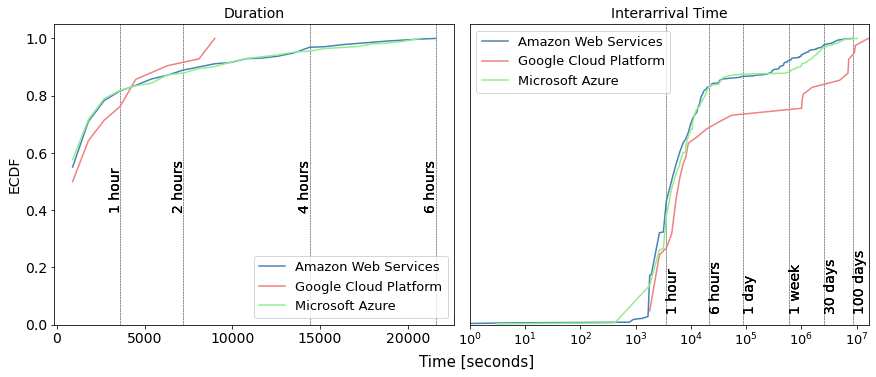

In [6]:
import math
cdf_duration = duration_cdf_df.sort_values('cdf', inplace=False)[['duration', 'cdf', 'vendor_cat']]
cdf_ia = ia_cdf_df.sort_values('cdf', inplace=False)[['ia', 'cdf', 'vendor_cat', 'count']]
colors = ["steelblue", "lightcoral", "lightgreen"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
vendor_map = {
    'aws': 'Amazon Web Services',
    'gcp': "Google Cloud Platform",
    "azure": "Microsoft Azure"
}
for i, vendor in enumerate(["aws", "gcp", "azure"]):
    vendor_duration = cdf_duration[cdf_duration["vendor_cat"] == vendor]
    vendor_ia = cdf_ia[cdf_ia["vendor_cat"] == vendor]
    
    ax[0].plot(vendor_duration["duration"], vendor_duration["cdf"], label=vendor_map[vendor], color=colors[i])
    ax[0].set_ylim(0, 1.05)
    ax[0].set_title("Duration", fontsize=14)
    ax[0].set_ylabel("ECDF", fontsize=14)
    ax[0].legend(loc='lower right', ncol=1, fontsize=13)
    ax[0].tick_params(axis='both', labelsize=14)

    ax[1].plot(vendor_ia["ia"], vendor_ia["cdf"], label=vendor_map[vendor], color=colors[i])
    ax[1].set_title("Interarrival Time", fontsize=14)
    ax[1].legend(loc='upper left', ncol=1, fontsize=13)
    ax[1].tick_params(axis='both', labelsize=13)
    ax[1].get_yaxis().set_visible(False)
#     ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useOffset=False, useMathText=True)
    ax[1].set_xlim(-100000, 17000000)
    # Add vertical text to dashed lines in ax[0]
    hours = [60*60, 60*60*2, 60*60*4, 60*60*6]
    hour_str = ['1 hour', '2 hours', '4 hours', '6 hours']
    for i in range(len(hours)):
        ax[0].vlines(hours[i], ymin=0, ymax=1.1, linewidth=0.5, color='gray', ls='dashed')
        ax[0].text(hours[i]-650, 0.4, hour_str[i], rotation=90, fontsize=14)
    
    hours_2 = [60*60, 60*60*6, 60*60*24, 60*60*24*7, 60*60*24*30, 60*60*24*100]
    hour2_str = ['1 hour', '6 hours', '1 day', '1 week', '30 days', '100 days']
    for i in range(len(hours_2)):
        ax[1].vlines(hours_2[i], ymin=0, ymax=1.1, linewidth=0.5, color='gray', ls='dashed')
        ax[1].text(hours_2[i], 0.05, hour2_str[i], rotation=90, fontsize=14)
        
    ax[1].set_xscale('log')
    ax[0].set_xlabel('Time [seconds]', fontsize=15, loc='right')
    ax[0].xaxis.set_label_coords(+1.2, -0.1)
    
fig.tight_layout(pad=0.01)
plt.minorticks_off() 

plt.savefig(project_dir + "/plots/duration_ia_ecdf.pdf", dpi=100)

In [7]:
# Checking the percentiles
def check_percentiles(df, q):
    partial_df = df[df["cdf"] >= q-0.05]
    return partial_df[partial_df["cdf"] < q+0.05]

print("gcp: " + str(check_percentiles(ia_cdf_df[ia_cdf_df["vendor_cat"] == "gcp"], 0.86)["ia"].max() / (24*3600)))
print("aws: " + str(check_percentiles(ia_cdf_df[ia_cdf_df["vendor_cat"] == "aws"], 0.86)["ia"].max() / (24*3600)))
print("azure: " + str(check_percentiles(ia_cdf_df[ia_cdf_df["vendor_cat"] == "azure"], 0.86)["ia"].max() / (24*3600)))

gcp: 82.0915625
aws: 5.532662037037037
azure: 11.585416666666667


In [8]:
check_percentiles(ia_cdf_df[ia_cdf_df["vendor_cat"] == "aws"], 0.86)

,ia,count,prop,cdf,vendor_cat
31,17100.0,5,0.011086,0.815965,aws
32,18000.0,2,0.004435,0.820399,aws
33,18900.0,1,0.002217,0.822616,aws
34,19800.0,3,0.006652,0.829268,aws
35,21600.0,1,0.002217,0.831486,aws
36,22500.0,1,0.002217,0.833703,aws
37,23399.0,1,0.002217,0.835920,aws
38,23400.0,1,0.002217,0.838137,aws
39,24300.0,2,0.004435,0.842572,aws
40,31500.0,1,0.002217,0.844789,aws


<ipython-input-14-6f047a87efb7>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-14-6f047a87efb7>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


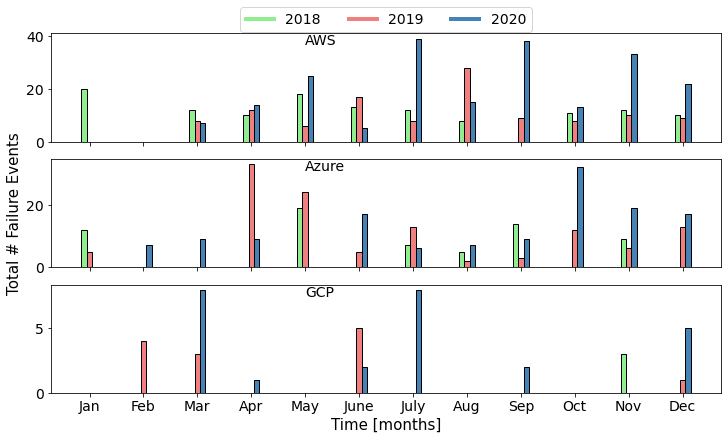

In [14]:
# Total num failure events per month per year
from matplotlib.lines import Line2D

colors=["lightgreen", "lightcoral", "steelblue"]
years = [2018, 2019, 2020]
bar_w = 0.1
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
colors = ["lightgreen", "lightcoral", "steelblue"]
providers = df.sort_values("provider")["provider"].unique()
provider_map = {
    'aws': "AWS", 
    "gcp": "GCP",
    "azure": "Azure"
}
fig, ax = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True)
for i, vendor in enumerate(providers):
    partial_df = extract_failure_event_times(df[df["provider"] == vendor])
    partial_df["date"] = pd.to_datetime(partial_df['start_time'], unit='s')
    
    partial_df["year"] = partial_df["date"].dt.year
    partial_df["month"] = partial_df["date"].dt.month
    
    bar_locs = []
    bar_heights = []
    months = [i for i in range(1, 13)]
    dfs = {2018: [], 2019: [], 2020: []}
    
    df_vendor = partial_df
    for year in years:
        df_year_vendor = df_vendor[df_vendor["year"] == year]
        partial_grouped_df = df_year_vendor.groupby('month')['event_id'].unique().str.len().reset_index().rename(columns={'event_id': 'event_sum'})
        for m in months:
            if m not in partial_grouped_df["month"].values:
                partial_grouped_df = partial_grouped_df.append({'month': m, 'event_sum': 0}, ignore_index=True)
            
            partial_grouped_df = partial_grouped_df.sort_values("month")        
        dfs[year] = partial_grouped_df
    
    for idx, m in enumerate(months):
        df_months = []
        for year in years:
            dfi = dfs[year]
            df_m = dfi[dfi["month"] == m]
            df_months.append(df_m)
            
        bar_locs.extend([idx - bar_w, idx, idx + bar_w])
        bar_heights.extend([df_months[0]['event_sum'].values[0], df_months[1]['event_sum'].values[0], df_months[2]['event_sum'].values[0]])

    ax[i].bar(
         x=bar_locs, 
         height=bar_heights, 
         width=bar_w, 
         align='center',
         color=colors * int(len(bar_heights) / 3),
         edgecolor='black'
    )
    
    ax[i].set_ylim(0, )
    if i != len(providers) - 1:
        ax[i].set_xticklabels([])
        
    ax[0].legend(custom_lines, ['2018', '2019', '2020'], ncol=3, loc='center', bbox_to_anchor=(0.5, 1.13), fontsize=14)
    ax[1].set_ylabel("Total # Failure Events", fontsize=15)
    ax[2].set_xlabel("Time [months]", fontsize=15)
    ax[i].tick_params(axis='both', labelsize=14)
    if vendor == "gcp":
        ax[i].text(x=4, y=max(bar_heights)-0.5, s=provider_map[vendor], fontsize=14)
    else:
        ax[i].text(x=4, y=max(bar_heights)-2.1, s=provider_map[vendor], fontsize=14)
    ax[i].set_xticks([month for month in range(0, 12)])
    ax[2].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=14)
    
    
    bar_locs = []
    bar_heights = []
    
plt.savefig(project_dir + "/plots/monthly_yearly_total_num_failure_events_barplots.pdf", dpi=100)

In [7]:
# Analysis for nr of failure events
for vendor in ['aws', 'gcp', 'azure']:
    partial_df = extract_failure_event_times(df[df["provider"] == vendor])
    print(vendor + ": " + str(partial_df["event_id"].count()))



aws: 452
gcp: 42
azure: 314


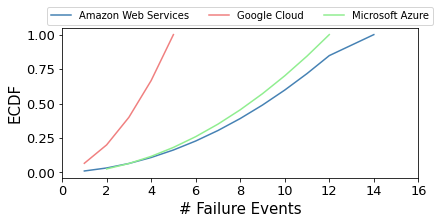

In [17]:
vendor_map = {
    'aws': "Amazon Web Services", 
    "gcp": "Google Cloud",
    "azure": "Microsoft Azure"
}
colors = ["steelblue", "lightcoral", "lightgreen"]
def compute_cdf(partial_df, variate):
    count_df = partial_df.groupby('page_id')['event_id'].count().reset_index().rename(columns={'event_id':'event_count'}).sort_values('event_count').reset_index(drop=True)
    count_df = count_df.groupby('event_count')['page_id'].count().reset_index().rename(columns={'page_id':'page_count'}).sort_values('page_count').reset_index(drop=True)
    count_df = count_df.sort_values('event_count')
    count_df['prop'] = count_df['event_count'].values / count_df['event_count'].sum()
    count_df['cdf'] = count_df['prop'].cumsum()
    return count_df

fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for i, vendor in enumerate(["aws", "gcp", "azure"]):
    df_vendor = extract_failure_event_times(df[df["provider"] == vendor])
    df_cdf_events_per_page = compute_cdf(df_vendor, 'page_id').sort_values('event_count', inplace=False)
    ax.plot(df_cdf_events_per_page["event_count"], df_cdf_events_per_page["cdf"], label=vendor_map[vendor], color=colors[i])

ax.set_xlim(0, 16)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.08), ncol=3)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("# Failure Events", fontsize=15)
ax.set_ylabel("ECDF", fontsize=15)
plt.savefig(project_dir + "/plots/user_nr_failures_per_page.pdf", dpi=100)

In [18]:
def compute_cdf(partial_df, variate):
    count_df = partial_df.groupby('page_id')['event_id'].count().reset_index().rename(columns={'event_id':'event_count'}).sort_values('event_count').reset_index(drop=True)
    count_df = count_df.groupby('event_count')['page_id'].count().reset_index().rename(columns={'page_id':'page_count'}).sort_values('page_count').reset_index(drop=True)
    count_df = count_df.sort_values('event_count')
    count_df['prop'] = count_df['event_count'].values / count_df['event_count'].sum()
    count_df['cdf'] = count_df['prop'].cumsum()
    return count_df

for i, vendor in enumerate(["aws", "gcp", "azure"]):
    df_vendor = extract_failure_event_times(df[df["provider"] == vendor])
    df_cdf_events_per_page = compute_cdf(df_vendor, 'page_id').sort_values('event_count', inplace=False)
    print(vendor)
    print(df_cdf_events_per_page)
    print

aws
    event_count  page_count      prop       cdf
0             1           1  0.010870  0.010870
5             2           5  0.021739  0.032609
3             3           4  0.032609  0.065217
11            4           9  0.043478  0.108696
12            5          10  0.054348  0.163043
9             6           8  0.065217  0.228261
8             7           7  0.076087  0.304348
7             8           6  0.086957  0.391304
6             9           5  0.097826  0.489130
10           10           8  0.108696  0.597826
1            11           1  0.119565  0.717391
4            12           4  0.130435  0.847826
2            14           1  0.152174  1.000000
gcp
   event_count  page_count      prop       cdf
0            1           2  0.066667  0.066667
1            2           2  0.133333  0.200000
2            3           3  0.200000  0.400000
3            4           3  0.266667  0.666667
4            5           3  0.333333  1.000000
azure
    event_count  page_count     